1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [10]:
# Necssary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
pd.set_option('display.max_columns', 500)
%matplotlib inline
import random

# General syntax to import a library but no functions: 
##import (library) as (give the library a nickname/alias)
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import io
import requests

#colnames=['Default','Student','Balance','Income']
df =pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv", index_col=0)


#url = "https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv"

#s = requests.get(url).content
#df = pd.read_csv(io.StringIO(s.decode('utf-8')))

df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [14]:
df["default"] = df["default"].astype('category')
df["student"] = df["student"].astype('category')

df.dtypes

default    category
student    category
balance     float64
income      float64
dtype: object

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

In [26]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])

df_final = pd.concat([df[['balance','income']],df_default, df_student],axis=1)

df_final=df_final.drop(['?'],1)
df_final.shape

df.head()
#df_final.boxplot()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [27]:
indices = np.where(df.default == 'No')[0]
rng = np.random.RandomState(13)
rng.shuffle(indices)
n_pos = (df.default == 'Yes').sum()
df = df.drop(df.index[indices[n_pos:]])

df.head()

,default,student,balance,income
20,No,No,1095.072735,26464.631389
38,No,No,351.453472,35087.488648
61,No,No,766.234379,46478.294257
78,No,No,728.373251,45131.718265
79,No,No,76.991291,28392.093412


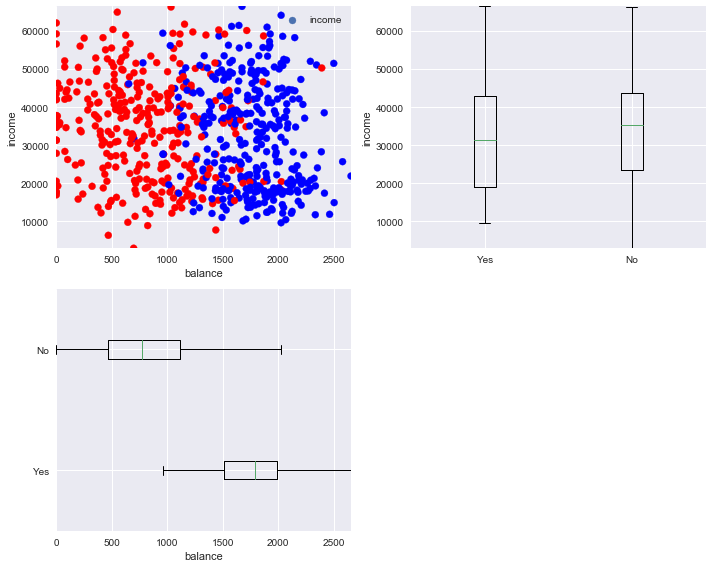

In [29]:
from matplotlib.colors import ListedColormap

# setup figure
plt.figure(figsize=(10, 8))

# scatter plot of balance (x) and income (y)
ax1 = plt.subplot(221)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax1.scatter(df.balance, df.income, c=(df.default == 'Yes'), cmap=cm_bright)        
ax1.set_xlim((df.balance.min(), df.balance.max()))
ax1.set_ylim((df.income.min(), df.income.max()))
ax1.set_xlabel('balance')
ax1.set_ylabel('income')
ax1.legend(loc='upper right')

# box plots for income
ax2 = plt.subplot(222)
ax2.boxplot([df.income[df.default == 'Yes'], df.income[df.default == 'No']])
ax2.set_ylim((df.income.min(), df.income.max()))
ax2.set_xticklabels(('Yes', 'No'))
ax2.set_ylabel('income')

# box plots for balance
ax3 = plt.subplot(223)
ax3.boxplot([df.balance[df.default == 'Yes'], df.balance[df.default == 'No']], vert=0)
ax3.set_xlim((df.balance.min(), df.balance.max()))
ax3.set_yticklabels(('Yes', 'No'))
ax3.set_xlabel('balance')
plt.tight_layout()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

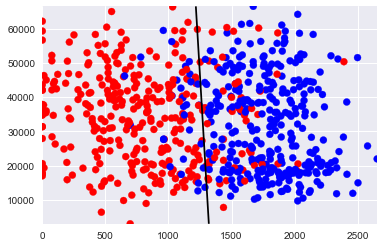

In [41]:
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

# utility function to plot the decision surface
def plot_surface(est, x_1, x_2, ax=None, threshold=0.0, contourf=False):
    """Plots the decision surface of ``est`` on features ``x1`` and ``x2``. """
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))
    # plot the hyperplane by evaluating the parameters on the grid
    X_pred = np.c_[xx1.ravel(), xx2.ravel()]  # convert 2d grid into seq of points
    if hasattr(est, 'predict_proba'):  # check if ``est`` supports probabilities
        # take probability of positive class
        pred = est.predict_proba(X_pred)[:, 1]
    else:
        pred = est.predict(X_pred)
    Z = pred.reshape((100, 100))  # reshape seq to grid
    if ax is None:
        ax = plt.gca()
    # plot line via contour plot

    if contourf:
        ax.contourf(xx1, xx2, Z, levels=np.linspace(0, 1.0, 10), cmap=plt.cm.RdBu, alpha=0.6)
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))
    
# get feature/predictor matrix as numpy array
X = df[['balance', 'income']].values

# encode class labels
classes, y = np.unique(df.default.values, return_inverse=True)
y = (y * 2) - 1  # map {0, 1} to {-1, 1}

# fit OLS regression 
est = LinearRegression(fit_intercept=True, normalize=True)
est.fit(X, y)

# plot data and decision surface
ax = plt.gca()
ax.scatter(df.balance, df.income, c=(df.default == 'Yes'), cmap=cm_bright)

plot_surface(est, X[:, 0], X[:, 1], ax=ax)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

8) Find the optimal decision tree depth and compute the AUC ROC. 